**Soil-air interface.**

Using the functionality of COMETS, one can design simulations which go beyond in silico corollaries of lab experiments to make predictions for environments mimicking natural ecosystems, which is a necessary step for understanding natural ecology from first principles. In this example, we consider a simulation of a soil environment. We use source-and-sink functions to model how a root provides organic acids to the environment while removing ammonia (Huang et al 2014 Botany). While we restrict the root functionality to a source/sink, one could use functionality demonstrated above, for example extracellular enzymes, to generate feedback loops between microbe-produced metabolites and root exudation. We use fixed metabolite concentrations to mimic the largely unchanging air interface above a root, which generates an oxygen gradient. Additionally, since soil is characterized by strong spatial structure with many impenetrable barriers that localized interactions (Nunan 2017), we place “rock” barriers throughout the simulation area. A more complex simulation could use varying diffusion constants for metabolites, as described in a previous protocol (Virtual Petri Dish). Similarly, we use standard diffusion of biomass, but this could be changed to use pushing force or non-linear diffusion for a potentially increased realism.

In [1]:
import cobra
import cobra.test # for the ijo1366 model
import sys
import copy
import numpy as np
import cometspy as c

For the strain models, we use three well-curated soil bacteria, Pseudomonas putida (model iJN747), Bacillus subtilis (model iYO844), and Methanosarcina barkeri (model iAF629), which are available in the BIGG database (King et al 2016).

Also, upon loading, the biomass functions of these models had positive lower bounds, which we then set to zero. 

In [2]:
model_dir = "/home/jeremy/Dropbox/work_related/harcombe_lab/segre/soil_root_eg" # model location
iJN = cobra.io.read_sbml_model(model_dir + '/iJN746.xml')
iJN.reactions.get_by_id('BIOMASS_KT_TEMP').lower_bound = 0
iJN.reactions.get_by_id('BIOMASS_KT_TEMP').upper_bound = 1000

iAF = cobra.io.read_sbml_model(model_dir + '/iAF692.xml')
iAF.reactions.get_by_id('BIOMASS_Mb_30').lower_bound = 0
iAF.reactions.get_by_id('BIOMASS_Mb_30').upper_bound = 1000

iYO = cobra.io.read_sbml_model(model_dir + '/iYO844.xml')
iYO.reactions.get_by_id('BIOMASS_BS_10').lower_bound = 0
iYO.reactions.get_by_id('BIOMASS_BS_10').upper_bound = 1000

Next, we convert these into COMETS models. We also use some helper functions to a) ensure the COMETS model does not think "sink" reactions are exchange reactions (as they are unbalanced in Cobra models, and therefore appear similar to exchanges), and b) open all exchange reaction bounds, to make sure that COMETS is in control of the media composition.

In [3]:
iJN_comets = c.model(iJN)
iJN_comets.ensure_sinks_are_not_exchanges()
iJN_comets.open_exchanges()

iAF_comets = c.model(iAF)
iAF_comets.ensure_sinks_are_not_exchanges()
iAF_comets.open_exchanges()

iYO_comets = c.model(iYO)
iYO_comets.ensure_sinks_are_not_exchanges()
iYO_comets.open_exchanges()

Our simulated world will be a 100x100 box lattice. The left-hand side, where x = 0, will be the root. The top, where y = 0, will be the air. Therefore, the biomass and the rocks will be distributed everywhere else. To ensure that we don't attempt to place biomass where rocks are placed, we first determine the rock locations. Specifically, we will create 70 rocks which are impervious to any biomass or metabolite. These rocks will have an average size of 15 boxes. To pick these locations, we use the helper function COMETS.grow_rocks:

In [27]:
grid_size = 50 # 100
n_rocks = 70 # 70
rock_locs = c.grow_rocks(n = n_rocks, xrange = [1,grid_size],yrange = [1,grid_size],mean_size = int(grid_size / 5))

Each species will have biomass seeded at 60 different locations, with no overlap. We will use the helper function pick_random_locations for this, which is useful as it can take in a previously-generated list of tuples of x-y locations as “forbidden” locations, such as the rock locations.

First we make a copy of the rock_locs so we don't accidentally alter it, and call this copy forbidden_locs.


In [28]:
import copy
forbidden_locs = copy.deepcopy(rock_locs)

Next we pick the random locations for each species, adding these locations to the forbidden locs as we go so as to prevent overlap.


In [29]:
founders_per_species = 20 # 60
iJN_locs = c.pick_random_locations(n = founders_per_species, 
                                   xrange = [1,grid_size], yrange = [1,grid_size], 
                                   forbidden_locs = forbidden_locs)
forbidden_locs.extend(iJN_locs)
iYO_locs = c.pick_random_locations(founders_per_species, [1,grid_size],[1,grid_size], forbidden_locs)
forbidden_locs.extend(iYO_locs)
iAF_locs = c.pick_random_locations(founders_per_species, [1,grid_size],[1,grid_size], forbidden_locs)
forbidden_locs.extend(iAF_locs)

If we wish to take a look at what locations were chosen, we can easily make an image with matplotlib:

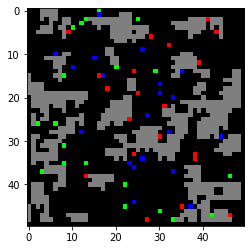

In [30]:
from matplotlib import pyplot as plt
initial_image = np.zeros((grid_size,grid_size,3))
for rock in rock_locs:
    initial_image[rock[1]-1,rock[0]-1,0:3] = 0.5 
for loc in iJN_locs:
    initial_image[loc[1]-1,loc[0]-1,0] = 1
for loc in iYO_locs:
    initial_image[loc[1]-1,loc[0]-1,1] = 1
for loc in iAF_locs:
    initial_image[loc[1]-1,loc[0]-1,2] = 1
plt.imshow(initial_image)

Things look good so we continue by making the layout and setting the dimensions. Then, we add the rock barriers to the layout.

In [31]:
layout = c.layout()
layout.grid = [grid_size,grid_size]
layout.add_barriers(rock_locs)

building empty layout model
models will need to be added with layout.add_model()


We set the initial population for each species by using a python list comprehension. Note that locations are properties of the model.

After setting initial populations, the models are finished, so we add them to the layout.

In [32]:
iJN_comets.initial_pop = [[loc[0],loc[1],1e-8] for loc in iJN_locs]
iYO_comets.initial_pop = [[loc[0],loc[1],1e-8] for loc in iYO_locs]
iAF_comets.initial_pop = [[loc[0],loc[1],1e-8] for loc in iAF_locs]

layout.add_model(iJN_comets)
layout.add_model(iYO_comets)
layout.add_model(iAF_comets)

We want some metabolites available initially. These include all the typical trace nutrients needed, so we start with the helper function.

After that, however, we want oxygen to mostly diffuse from the air, so we set that value lower. We also add a few other trace metabolites homogeneously throughout the environment that were not added with the helper function.

In [33]:
layout.add_typical_trace_metabolites()
layout.set_specific_metabolite('o2_e',0.00001)
layout.set_specific_metabolite('hco3_e',1000)
layout.set_specific_metabolite('co2_e',1000)
layout.set_specific_metabolite('h2_e',1000)
layout.set_specific_metabolite('so3_e',1000)
layout.set_specific_metabolite('nh4_e',0.000001)

layout.set_specific_metabolite('glc__D_e',0.0000001)
layout.set_specific_metabolite('meoh_e',0.00000001)
layout.set_specific_metabolite('cys__L_e',0.0000001)
layout.set_specific_metabolite('4abz_e',0.0000001)
layout.set_specific_metabolite('nac_e',0.00000001)

To make the air layer, we set static media, which keep that metabolite at a fixed value.  We also set a static level of zero oxygen at the "bottom," to mimic continuous downwards diffusion.

In a similar fashion, we set a static sink of ammonium where the “root” is.

In [34]:
# set static media of O2 and CO2 at the top and bottom-- the "air" and continuous loss of O2 downwards
for x in range(grid_size):
    layout.set_specific_static_at_location('o2_e', (x,0), .0001) # top
    layout.set_specific_static_at_location('o2_e', (x,grid_size-1), 0.) # bottom
    layout.set_specific_static_at_location('co2_e', (x,0), .0001)
    
for x in range(grid_size):
    layout.set_specific_static_at_location('nh4_e', (0,x), 0.0)

In contrast to ammonia, which we assume is always entirely consumed by the root, we assume the root drips organic acids and methanol into the environment at fixed rate, so we use a refresh function.

In [35]:
for x in range(grid_size):
    layout.set_specific_refresh_at_location('cit_e', (0,x), .000001)
    layout.set_specific_refresh_at_location('meoh_e', (0,x), .000001)
    layout.set_specific_refresh_at_location('succ_e', (0,x), .000001)

We are now done prepping the models and the layout. Next we setup the simulation parameters. Note the positive death rate.


In [36]:
params = c.params()
params.set_param('timeStep', 0.1)
params.set_param('maxCycles', 5000)
params.set_param('maxSpaceBiomass', 10)
params.set_param('deathRate', 0.0001) # die at rate of 1/10000 per hour
params.set_param('writeBiomassLog', True)
params.set_param('BiomassLogRate', 500)
params.set_param('writeMediaLog', True)
params.set_param('MediaLogRate', 500)
params.set_param("writeFluxLog", True)
params.set_param("FluxLogRate", 500)
params.set_param('numRunThreads', 3)
params.set_param('defaultKm', 0.000001)

In [ ]:
sim = c.comets(layout, params)
sim.run(False)

    specifically, we cannot find the following libraries at these locations:

library common name 	 expected path
___________________ 	 _____________
gurobi	/opt/gurobi900/linux64/gurobi.jar
junit	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/junit-4.12.jar
hamcrest	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/junit/hamcrest-core-1.3.jar
jogl_all	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all.jar
gluegen_rt	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt.jar
gluegen	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen.jar
gluegen_rt_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/gluegen-rt-natives-linux-amd64.jar
jogl_all_natives	/Dropbox/work_related/harcombe_lab/segre/comets/bin/lib/jogl/jogamp-all-platforms/jar/jogl-all-natives-linux-amd64.jar
jmatio	/Dropbox/work_related/ha

In [ ]:
print(sim.run_output)

Now we make a simulation object and run it.  This can take awhile.

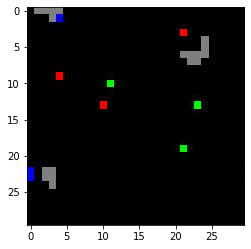

In [26]:
im = sim.get_biomass_image('iJN746', params.all_params['maxCycles'])
im2 = sim.get_biomass_image('iYO844',params.all_params['maxCycles'])
im3 = sim.get_biomass_image('iAF692',params.all_params['maxCycles'])

final = np.zeros((grid_size,grid_size,3))
final[:,:,0] = im / np.max(im)
final[:,:,1] = im2 / np.max(im2)
final[:,:,2] = im3 / np.max(im3)
for rock in rock_locs:
    final[rock[1]-1,rock[0]-1,0:3] = 0.5 
from matplotlib import pyplot as plt
import matplotlib.colors, matplotlib.cm
my_cmap = matplotlib.cm.get_cmap("copper")
my_cmap.set_bad((0,0,0))

plt.imshow(final)

In [ ]:
sim.biomass_backup = sim.biomass

In [ ]:
sim.biomass = sim.biomass.groupby(["cycle","x","y"]).sum().reset_index()

In [ ]:
sim.biomass = sim.biomass_backup

In [16]:
sim.biomass

,cycle,x,y,species,biomass
0,0,4,22,iJN746,1.000000e-08
1,0,4,22,iYO844,0.000000e+00
2,0,4,22,iAF692,0.000000e+00
3,0,10,5,iJN746,1.000000e-08
4,0,10,5,iYO844,0.000000e+00
...,...,...,...,...,...
2668,10,29,28,iYO844,0.000000e+00
2669,10,29,28,iAF692,0.000000e+00
2670,10,29,29,iJN746,0.000000e+00
2671,10,29,29,iYO844,0.000000e+00


In [ ]:
im2